In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid
from os import listdir, makedirs
from os.path import join, exists, expanduser
from tqdm import tqdm
from sklearn.metrics import log_loss, accuracy_score
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications import xception
from keras.applications import inception_v3
from keras.applications.vgg16 import preprocess_input, decode_predictions
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.6/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
INPUT_SIZE = 224
NUM_CLASSES = 120
SEED = 1987
data_dir = 'dog-breed-identification'
labels = pd.read_csv(join(data_dir, 'labels.csv'))
sample_submission = pd.read_csv(join(data_dir, 'sample_submission.csv'))
print(len(listdir(join(data_dir, 'train'))), len(labels))
print(len(listdir(join(data_dir, 'test'))), len(sample_submission))


10222 10222
10358 10357


In [ ]:
# preparing the train dataset

train_img=[]
for i in range(len(train)):
    temp_img=image.load_img(data_dir+train['filename'][i],target_size=(224,224))
    temp_img=image.img_to_array(temp_img)
    train_img.append(temp_img)

#converting train images to array and applying mean subtraction processing
train_img=np.array(train_img) 
train_img=preprocess_input(train_img)
# applying the same procedure with the test dataset

test_img=[]
for i in range(len(test)):
    temp_img=image.load_img(data_dir+test['filename'][i],target_size=(224,224))
    temp_img=image.img_to_array(temp_img)
    test_img.append(temp_img)

test_img=np.array(test_img) 
test_img=preprocess_input(test_img)

In [3]:
selected_breed_list = list(labels.groupby('breed').count().sort_values(by='id', ascending=False).head(NUM_CLASSES).index)
labels = labels[labels['breed'].isin(selected_breed_list)]
labels['target'] = 1
labels['rank'] = labels.groupby('breed').rank()['id']
labels_pivot = labels.pivot('id', 'breed', 'target').reset_index().fillna(0)
np.random.seed(seed=SEED)
rnd = np.random.random(len(labels))
train_idx = rnd < 0.8
valid_idx = rnd >= 0.8
y_train = labels_pivot[selected_breed_list].values
ytr = y_train[train_idx]
yv = y_train[valid_idx]
print(y_train.shape)

(10222, 120)


In [4]:
Y_train = ytr
Y_valid = yv

In [6]:
def read_img(img_id, train_or_test, size):

    img = image.load_img(join(data_dir, train_or_test, '%s.jpg' % img_id), target_size=size)
    img = image.img_to_array(img)
    return img

In [ ]:
#test on ResNet make sure everything is loading right
model = VGG16(weights='imagenet', include_top=False)
j = int(np.sqrt(NUM_CLASSES))
i = int(np.ceil(1. * NUM_CLASSES / j))
fig = plt.figure(1, figsize=(16, 16))
grid = ImageGrid(fig, 111, nrows_ncols=(i, j), axes_pad=0.05)
for i, (img_id, breed) in enumerate(labels.loc[labels['rank'] == 1, ['id', 'breed']].values):
    ax = grid[i]
    img = read_img(img_id, 'train', (224, 224))
    ax.imshow(img / 255.)
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    preds = model.predict(x)
    _, imagenet_class_name, prob = decode_predictions(preds, top=1)[0][0]
    ax.text(10, 180, 'ResNet50: %s (%.2f)' % (imagenet_class_name , prob), color='w', backgroundcolor='k', alpha=0.8)
    ax.text(10, 200, 'LABEL: %s' % breed, color='k', backgroundcolor='w', alpha=0.8)
    ax.axis('off')
plt.show()

In [12]:
INPUT_SIZE = 224
POOLING = 'avg'
x_train = np.zeros((len(labels), INPUT_SIZE, INPUT_SIZE, 3), dtype='float32')
for i, img_id in tqdm(enumerate(labels['id'])):
    img = read_img(img_id, 'train', (INPUT_SIZE, INPUT_SIZE))
    x = preprocess_input(np.expand_dims(img.copy(), axis=0))
    x_train[i] = x
print('Train Images shape: {} size: {:,}'.format(x_train.shape, x_train.size))

10222it [03:02, 56.16it/s]

Train Images shape: (10222, 125, 125, 3) size: 479,156,250


In [50]:
Xtr = x_train[train_idx]
Xv = x_train[valid_idx]
print((Xtr.shape, Xv.shape, ytr.shape, yv.shape))

((8140, 125, 125, 3), (2082, 125, 125, 3), (8140, 120), (2082, 120))


In [14]:
import time
import numpy
from keras.datasets import mnist
from keras.models import Model
from keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras import backend as K
from keras.optimizers import Adam

K.set_image_dim_ordering( 'tf' )


In [22]:
def inception2BN(x, n = 32):
    p1 = Conv2D(n, 1, padding='same')(x)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    p2 = Conv2D(n, 1, padding='same')(x)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n, 3, padding='same')(p2)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)    
    p3 = Conv2D(n, 1, padding='same')(x)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)    
    p3 = Conv2D(n, 5, padding='same')(p3)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)  
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)    
    p4 = Conv2D(n, 1, padding='same')(p4)
    p4 = BatchNormalization()(p4)
    p4 = Activation('relu')(p4)     

    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

In [23]:
def model3():
    inputs = Input(Xtr.shape[1:])
    i1 = inception2BN(inputs)
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception2BN(mp1)
    mp2 = MaxPooling2D((2,2))(i2)
    i3 = inception2BN(mp2)
    mp3 = MaxPooling2D((2,2))(i3) 
    i4 = inception2BN(mp3)
    mp4 = MaxPooling2D((2,2))(i4) 
    f = Flatten()(mp4)
    d = Dense(128)(f)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    out = Dense(120, activation='softmax')(d)
    model = Model(inputs, out)
    return model

In [24]:
model3=model3()
model3.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 125, 125, 3)  0                                            
__________________________________________________________________________________________________
conv2d_50 (Conv2D)              (None, 125, 125, 32) 128         input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_52 (Conv2D)              (None, 125, 125, 32) 128         input_4[0][0]                    
__________________________________________________________________________________________________
batch_normalization_52 (BatchNo (None, 125, 125, 32) 128         conv2d_50[0][0]                  
__________________________________________________________________________________________________
batch_norm

Train on 6512 samples, validate on 1628 samples
Epoch 1/30
 - 75s - loss: 4.9456 - acc: 0.0114 - val_loss: 4.8481 - val_acc: 0.0147
Epoch 2/30
 - 61s - loss: 4.5299 - acc: 0.0433 - val_loss: 4.7359 - val_acc: 0.0240
Epoch 3/30
 - 61s - loss: 4.2641 - acc: 0.0977 - val_loss: 4.6825 - val_acc: 0.0338
Epoch 4/30
 - 61s - loss: 4.0165 - acc: 0.1744 - val_loss: 4.6519 - val_acc: 0.0393
Epoch 5/30
 - 61s - loss: 3.7969 - acc: 0.2621 - val_loss: 4.6173 - val_acc: 0.0479
Epoch 6/30
 - 61s - loss: 3.5816 - acc: 0.3561 - val_loss: 4.6035 - val_acc: 0.0485
Epoch 7/30
 - 61s - loss: 3.3753 - acc: 0.4622 - val_loss: 4.5892 - val_acc: 0.0461
Epoch 8/30
 - 61s - loss: 3.1684 - acc: 0.5630 - val_loss: 4.5808 - val_acc: 0.0491
Epoch 9/30
 - 61s - loss: 2.9820 - acc: 0.6505 - val_loss: 4.5757 - val_acc: 0.0522
Epoch 10/30
 - 61s - loss: 2.7947 - acc: 0.7185 - val_loss: 4.5763 - val_acc: 0.0522
Epoch 11/30
 - 61s - loss: 2.6111 - acc: 0.7927 - val_loss: 4.5667 - val_acc: 0.0522
Epoch 12/30
 - 61s - loss:

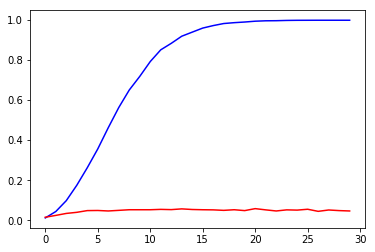

In [20]:
model3 = model3()
adam = Adam(lr=0.0001)
model3.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log3 = model3.fit(Xtr, ytr, validation_split=0.2, epochs=30, batch_size=150, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores3 = model3.evaluate(Xv, yv, verbose=0)
print("CNN Error: %.2f%%" % (100-scores3[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log3.history['acc'],'b') 
plt.plot(log3.history['val_acc'],'r')
plt.show()

In [ ]:
#CNN Error: 95.05%
#Overfit- add some dropout and 
#try sigmoid rather than softmax and 
#try with larger batchsize

In [39]:
def inception2DO(x, n = 32):
    p1 = Conv2D(n, 1, padding='same')(x)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    p1 = Dropout(0.01)(p1)
    p2 = Conv2D(n, 1, padding='same')(x)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n, 3, padding='same')(p2)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Dropout(0.01)(p2)
    p3 = Conv2D(n, 1, padding='same')(x)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)    
    p3 = Conv2D(n, 5, padding='same')(p3)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)
    p3 = Dropout(0.01)(p3)
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)    
    p4 = Conv2D(n, 1, padding='same')(p4)
    p4 = BatchNormalization()(p4)
    p4 = Activation('relu')(p4)
    p4 = Dropout(0.01)(p4)

    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

In [43]:
def model4():
    inputs=Input(Xtr.shape[1:])
    c2 = Conv2D(32, 7, padding='same')(inputs)
    c2 = MaxPooling2D((2,2))(c2)
    c2 = Conv2D(32, 1, padding='same')(c2)
    c2 = MaxPooling2D((2,2))(c2)
    i1 = inception2DO(c2)
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception2DO(mp1)
    mp2 = MaxPooling2D((2,2))(i2)
    i3 = inception2DO(mp2)
    mp3 = MaxPooling2D((2,2))(i3) 
    i4 = inception2DO(mp3)
    mp4 = MaxPooling2D((2,2))(i4) 
    f = Flatten()(mp4)
    d = Dense(128)(f)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    out = Dense(120, activation='sigmoid')(d)
    model = Model(inputs, out)
    return model

In [44]:
model4 = model4()
model4.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 125, 125, 3)  0                                            
__________________________________________________________________________________________________
conv2d_177 (Conv2D)             (None, 125, 125, 32) 4736        input_9[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_66 (MaxPooling2D) (None, 62, 62, 32)   0           conv2d_177[0][0]                 
__________________________________________________________________________________________________
conv2d_178 (Conv2D)             (None, 62, 62, 32)   1056        max_pooling2d_66[0][0]           
__________________________________________________________________________________________________
max_poolin

In [48]:
inputs=Input(Xtr.shape[1:])

In [52]:
adam = Adam(lr=0.0001)
model4.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])



Train on 6512 samples, validate on 1628 samples
Epoch 1/30
 - 30s - loss: 4.8344 - acc: 0.0120 - val_loss: 4.8143 - val_acc: 0.0080
Epoch 2/30
 - 13s - loss: 4.7687 - acc: 0.0121 - val_loss: 4.8021 - val_acc: 0.0123
Epoch 3/30
 - 13s - loss: 4.7202 - acc: 0.0157 - val_loss: 4.7912 - val_acc: 0.0098
Epoch 4/30
 - 13s - loss: 4.6740 - acc: 0.0192 - val_loss: 4.7776 - val_acc: 0.0117
Epoch 5/30
 - 13s - loss: 4.6358 - acc: 0.0217 - val_loss: 4.7701 - val_acc: 0.0135
Epoch 6/30
 - 13s - loss: 4.6022 - acc: 0.0275 - val_loss: 4.7624 - val_acc: 0.0117
Epoch 7/30
 - 13s - loss: 4.5673 - acc: 0.0344 - val_loss: 4.7521 - val_acc: 0.0117
Epoch 8/30
 - 13s - loss: 4.5333 - acc: 0.0384 - val_loss: 4.7445 - val_acc: 0.0129
Epoch 9/30
 - 13s - loss: 4.5027 - acc: 0.0464 - val_loss: 4.7408 - val_acc: 0.0135
Epoch 10/30
 - 13s - loss: 4.4723 - acc: 0.0554 - val_loss: 4.7334 - val_acc: 0.0141
Epoch 11/30
 - 13s - loss: 4.4416 - acc: 0.0643 - val_loss: 4.7228 - val_acc: 0.0154
Epoch 12/30
 - 13s - loss:

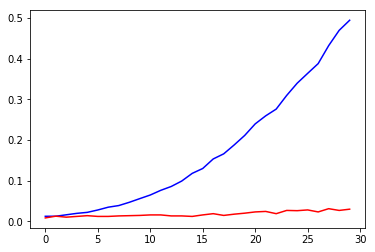

In [53]:
t0=time.time()
log4 = model4.fit(Xtr, ytr, validation_split=0.2, epochs=30, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")


scores4 = model4.evaluate(Xv, yv, verbose=0)
print("CNN Error: %.2f%%" % (100-scores4[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log4.history['acc'],'b') 
plt.plot(log4.history['val_acc'],'r')
plt.show()

CNN Error: 97.36%


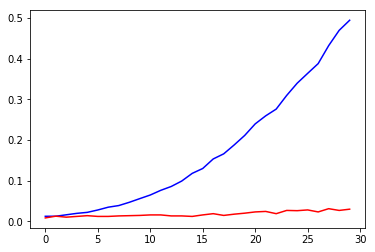

In [54]:
# Final evaluation of the model
scores4 = model4.evaluate(Xv, yv, verbose=0)
print("CNN Error: %.2f%%" % (100-scores4[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log4.history['acc'],'b') 
plt.plot(log4.history['val_acc'],'r')
plt.show()

In [55]:
#increase dropout
def inception3BN(x, n = 32):
    p1 = Conv2D(n, 1, padding='same')(x)
    p1 = BatchNormalization()(p1)
    p1 = Activation('tanh')(p1)
    p1 = Dropout(0.01)(p1)
    p2 = Conv2D(n, 1, padding='same')(x)
    p2 = BatchNormalization()(p2)
    p2 = Activation('tanh')(p2)
    p2 = Conv2D(n, 3, padding='same')(p2)
    p2 = BatchNormalization()(p2)
    p2 = Activation('tanh')(p2)
    p2 = Dropout(0.01)(p2)
    p3 = Conv2D(n, 1, padding='same')(x)
    p3 = BatchNormalization()(p3)
    p3 = Activation('tanh')(p3)    
    p3 = Conv2D(n, 5, padding='same')(p3)
    p3 = BatchNormalization()(p3)
    p3 = Activation('tanh')(p3)
    p3 = Dropout(0.01)(p3)
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)    
    p4 = Conv2D(n, 1, padding='same')(p4)
    p4 = BatchNormalization()(p4)
    p4 = Activation('tanh')(p4)
    p4 = Dropout(0.01)(p4)

    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

In [56]:
def model5():
    inputs = Input(Xtr.shape[1:])
    x = Conv2D(64, 7, activation ='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(32, 1, activation ='relu', padding='same')(x)
    x = Conv2D(32, 3, activation ='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    i1 = inception3BN(x)
    mp1 = MaxPooling2D((2,2))(i1)
    i2 = inception3BN(mp1)
    mp2 = MaxPooling2D((2,2))(i2)
    i3 = inception3BN(mp2)
    i3 = inception3BN(i3)
    mp3 = MaxPooling2D((2,2))(i3) 
    i4 = inception3BN(mp3)
    i4 = inception3BN(i4)
    mp4 = MaxPooling2D((2,2))(i4) 
    f = Flatten()(mp4)
    d = Dense(128)(f)
    d = BatchNormalization()(d)
    d = Activation('relu')(d)
    d = Dropout(0.5)(d)
    d = Dense(128)(f)
    d = BatchNormalization()(d)
    d = Activation('tanh')(d)
    d = Dropout(0.5)(d)
    out = Dense(120, activation='sigmoid')(d)
    model = Model(inputs, out)
    return model

In [57]:
model5 = model5()
model5.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_12 (InputLayer)           (None, 125, 125, 3)  0                                            
__________________________________________________________________________________________________
conv2d_203 (Conv2D)             (None, 125, 125, 64) 9472        input_12[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_76 (MaxPooling2D) (None, 62, 62, 64)   0           conv2d_203[0][0]                 
__________________________________________________________________________________________________
conv2d_204 (Conv2D)             (None, 62, 62, 32)   2080        max_pooling2d_76[0][0]           
__________________________________________________________________________________________________
conv2d_205

Train on 6512 samples, validate on 1628 samples
Epoch 1/30
 - 38s - loss: 4.8745 - acc: 0.0077 - val_loss: 4.8189 - val_acc: 0.0092
Epoch 2/30
 - 20s - loss: 4.8370 - acc: 0.0103 - val_loss: 4.8106 - val_acc: 0.0068
Epoch 3/30
 - 20s - loss: 4.8177 - acc: 0.0135 - val_loss: 4.7999 - val_acc: 0.0098
Epoch 4/30
 - 20s - loss: 4.7959 - acc: 0.0141 - val_loss: 4.7944 - val_acc: 0.0154
Epoch 5/30
 - 20s - loss: 4.7709 - acc: 0.0163 - val_loss: 4.7687 - val_acc: 0.0129
Epoch 6/30
 - 20s - loss: 4.7559 - acc: 0.0167 - val_loss: 4.7607 - val_acc: 0.0123
Epoch 7/30
 - 20s - loss: 4.7320 - acc: 0.0198 - val_loss: 4.7522 - val_acc: 0.0117
Epoch 8/30
 - 20s - loss: 4.7243 - acc: 0.0212 - val_loss: 4.7451 - val_acc: 0.0160
Epoch 9/30
 - 20s - loss: 4.7031 - acc: 0.0247 - val_loss: 4.7406 - val_acc: 0.0178
Epoch 10/30
 - 20s - loss: 4.6830 - acc: 0.0252 - val_loss: 4.7320 - val_acc: 0.0166
Epoch 11/30
 - 20s - loss: 4.6686 - acc: 0.0269 - val_loss: 4.7202 - val_acc: 0.0203
Epoch 12/30
 - 20s - loss:

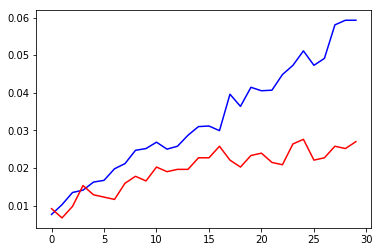

In [58]:
adam = Adam(lr=0.0001)
model5.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log5 = model5.fit(Xtr, ytr, validation_split=0.2, epochs=30, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores5 = model5.evaluate(Xv, yv, verbose=0)
print("CNN Error: %.2f%%" % (100-scores5[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log5.history['acc'],'b') 
plt.plot(log5.history['val_acc'],'r')
plt.show()

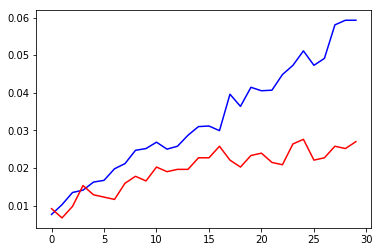

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log5.history['acc'],'b') 
plt.plot(log5.history['val_acc'],'r')
plt.show()

In [ ]:
#Prevent overfitting by simplifying the model

In [69]:
def model6():
    inputs = Input(Xtr.shape[1:])
    x = Conv2D(32, 1, activation ='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2))(x)
    i1 = inception3BN(x)
    d = MaxPooling2D((2,2))(i1)
    d = Flatten()(d)
    d = Dense(128)(d)
    d = BatchNormalization()(d)
    d = Activation('tanh')(d)
    d = Dropout(0.5)(d)
    out = Dense(120, activation='sigmoid')(d)
    model = Model(inputs, out)
    return model

In [70]:
model6 = model6()
model6.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 125, 125, 3)  0                                            
__________________________________________________________________________________________________
conv2d_266 (Conv2D)             (None, 125, 125, 32) 128         input_16[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_100 (MaxPooling2D (None, 62, 62, 32)   0           conv2d_266[0][0]                 
__________________________________________________________________________________________________
conv2d_268 (Conv2D)             (None, 62, 62, 32)   1056        max_pooling2d_100[0][0]          
__________________________________________________________________________________________________
conv2d_270

Train on 6512 samples, validate on 1628 samples
Epoch 1/30
 - 28s - loss: 4.7843 - acc: 0.0172 - val_loss: 4.6857 - val_acc: 0.0246
Epoch 2/30
 - 19s - loss: 4.6145 - acc: 0.0410 - val_loss: 4.6503 - val_acc: 0.0344
Epoch 3/30
 - 19s - loss: 4.5232 - acc: 0.0602 - val_loss: 4.6356 - val_acc: 0.0393
Epoch 4/30
 - 19s - loss: 4.4216 - acc: 0.1020 - val_loss: 4.6337 - val_acc: 0.0369
Epoch 5/30
 - 19s - loss: 4.3411 - acc: 0.1642 - val_loss: 4.6386 - val_acc: 0.0387
Epoch 6/30
 - 19s - loss: 4.2734 - acc: 0.2472 - val_loss: 4.6506 - val_acc: 0.0356
Epoch 7/30
 - 19s - loss: 4.2194 - acc: 0.3825 - val_loss: 4.6568 - val_acc: 0.0412
Epoch 8/30
 - 19s - loss: 4.1807 - acc: 0.5255 - val_loss: 4.6710 - val_acc: 0.0467
Epoch 9/30
 - 19s - loss: 4.1523 - acc: 0.6439 - val_loss: 4.6697 - val_acc: 0.0479
Epoch 10/30
 - 19s - loss: 4.1334 - acc: 0.7396 - val_loss: 4.6770 - val_acc: 0.0356
Epoch 11/30
 - 19s - loss: 4.1171 - acc: 0.8216 - val_loss: 4.6823 - val_acc: 0.0442
Epoch 12/30
 - 19s - loss:

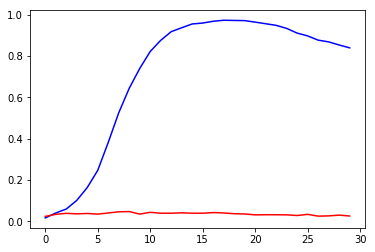

In [71]:
adam = Adam(lr=0.0001)
model6.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log6 = model6.fit(Xtr, ytr, validation_split=0.2, epochs=30, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores6 = model6.evaluate(Xv, yv, verbose=0)
print("CNN Error: %.2f%%" % (100-scores5[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log6.history['acc'],'b') 
plt.plot(log6.history['val_acc'],'r')
plt.show()

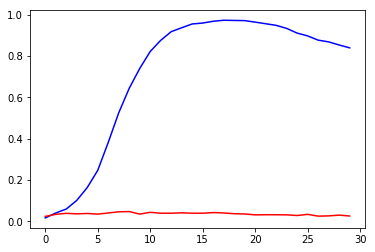

CNN Error: 96.69%


In [72]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log6.history['acc'],'b') 
plt.plot(log6.history['val_acc'],'r')
plt.show()
scores6 = model6.evaluate(Xv, yv, verbose=0)
print("CNN Error: %.2f%%" % (100-scores5[1]*100))


In [73]:
from keras.regularizers import l2 # L2-regularisation

l2_lambda = 0.0001


In [74]:
def inception2L(x, n = 32):
    p1 = Conv2D(n, 1, padding='same', kernel_regularizer=l2(l2_lambda))(x)
    p1 = BatchNormalization()(p1)
    p1 = Activation('relu')(p1)
    p1 = Dropout(0.01)(p1)
    p2 = Conv2D(n, 1, padding='same', kernel_regularizer=l2(l2_lambda))(x)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Conv2D(n, 3, padding='same', kernel_regularizer=l2(l2_lambda))(p2)
    p2 = BatchNormalization()(p2)
    p2 = Activation('relu')(p2)
    p2 = Dropout(0.01)(p2)
    p3 = Conv2D(n, 1, padding='same', kernel_regularizer=l2(l2_lambda))(x)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)    
    p3 = Conv2D(n, 5, padding='same', kernel_regularizer=l2(l2_lambda))(p3)
    p3 = BatchNormalization()(p3)
    p3 = Activation('relu')(p3)
    p3 = Dropout(0.01)(p3)
    p4 = MaxPooling2D((3,3), strides=(1, 1), padding='same')(x)    
    p4 = Conv2D(n, 1, padding='same', kernel_regularizer=l2(l2_lambda))(p4)
    p4 = BatchNormalization()(p4)
    p4 = Activation('relu')(p4)
    p4 = Dropout(0.01)(p4)

    c =  Concatenate(axis=-1)([p1,p2,p3,p4])
    return c

In [78]:
def model7():
    inputs = Input(Xtr.shape[1:])
    x = Conv2D(32, 1, activation ='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2))(x)
    i1 = inception2L(x)
    d = MaxPooling2D((2,2))(i1)
    d = Flatten()(d)
    d = Dense(128)(d)
    d = BatchNormalization()(d)
    d = Activation('tanh')(d)
    d = Dropout(0.5)(d)
    out = Dense(120, activation='sigmoid')(d)
    model = Model(inputs, out)
    return model

In [79]:
model7=model7()
model7.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_18 (InputLayer)           (None, 125, 125, 3)  0                                            
__________________________________________________________________________________________________
conv2d_274 (Conv2D)             (None, 125, 125, 32) 128         input_18[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_104 (MaxPooling2D (None, 62, 62, 32)   0           conv2d_274[0][0]                 
__________________________________________________________________________________________________
conv2d_276 (Conv2D)             (None, 62, 62, 32)   1056        max_pooling2d_104[0][0]          
__________________________________________________________________________________________________
conv2d_278

Train on 6512 samples, validate on 1628 samples
Epoch 1/30
 - 27s - loss: 4.8005 - acc: 0.0164 - val_loss: 4.7163 - val_acc: 0.0246
Epoch 2/30
 - 19s - loss: 4.5993 - acc: 0.0416 - val_loss: 4.6672 - val_acc: 0.0369
Epoch 3/30
 - 19s - loss: 4.4837 - acc: 0.0756 - val_loss: 4.6727 - val_acc: 0.0393
Epoch 4/30
 - 19s - loss: 4.3739 - acc: 0.1563 - val_loss: 4.6761 - val_acc: 0.0332
Epoch 5/30
 - 19s - loss: 4.2838 - acc: 0.2746 - val_loss: 4.6936 - val_acc: 0.0313
Epoch 6/30
 - 19s - loss: 4.2220 - acc: 0.4427 - val_loss: 4.6874 - val_acc: 0.0326
Epoch 7/30
 - 19s - loss: 4.1811 - acc: 0.6069 - val_loss: 4.7012 - val_acc: 0.0375
Epoch 8/30
 - 19s - loss: 4.1529 - acc: 0.7468 - val_loss: 4.6891 - val_acc: 0.0387
Epoch 9/30
 - 19s - loss: 4.1322 - acc: 0.8279 - val_loss: 4.6998 - val_acc: 0.0412
Epoch 10/30
 - 19s - loss: 4.1186 - acc: 0.8890 - val_loss: 4.6923 - val_acc: 0.0461
Epoch 11/30
 - 19s - loss: 4.1056 - acc: 0.9238 - val_loss: 4.6980 - val_acc: 0.0442
Epoch 12/30
 - 19s - loss:

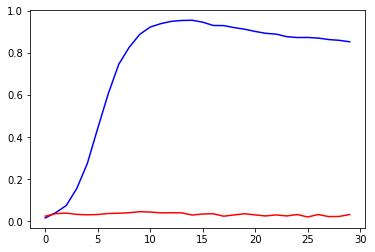

In [80]:
adam = Adam(lr=0.0001)
model7.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log7 = model7.fit(Xtr, ytr, validation_split=0.2, epochs=30, batch_size=200, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores7 = model7.evaluate(Xv, yv, verbose=0)
print("CNN7 Error: %.2f%%" % (100-scores5[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log7.history['acc'],'b') 
plt.plot(log7.history['val_acc'],'r')
plt.show()

CNN7 Error: 96.69%


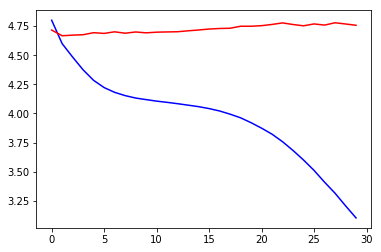

In [82]:
scores7 = model7.evaluate(Xv, yv, verbose=0)
print("CNN7 Error: %.2f%%" % (100-scores5[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log7.history['loss'],'b') 
plt.plot(log7.history['val_loss'],'r')
plt.show()

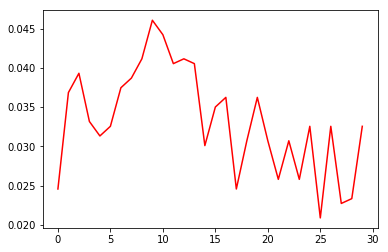

In [83]:
plt.plot(log7.history['val_acc'],'r')
plt.show()

Train on 6512 samples, validate on 1628 samples
Epoch 1/30
 - 29s - loss: 3.0051 - acc: 0.8564 - val_loss: 4.7551 - val_acc: 0.0258
Epoch 2/30
 - 18s - loss: 2.9263 - acc: 0.8576 - val_loss: 4.7654 - val_acc: 0.0276
Epoch 3/30
 - 18s - loss: 2.8453 - acc: 0.8546 - val_loss: 4.7483 - val_acc: 0.0289
Epoch 4/30
 - 18s - loss: 2.7867 - acc: 0.8546 - val_loss: 4.7565 - val_acc: 0.0362
Epoch 5/30
 - 18s - loss: 2.7173 - acc: 0.8510 - val_loss: 4.7633 - val_acc: 0.0295
Epoch 6/30
 - 18s - loss: 2.6538 - acc: 0.8533 - val_loss: 4.7635 - val_acc: 0.0313
Epoch 7/30
 - 18s - loss: 2.5912 - acc: 0.8460 - val_loss: 4.7576 - val_acc: 0.0362
Epoch 8/30
 - 18s - loss: 2.5256 - acc: 0.8449 - val_loss: 4.7604 - val_acc: 0.0350
Epoch 9/30
 - 18s - loss: 2.4738 - acc: 0.8421 - val_loss: 4.7706 - val_acc: 0.0276
Epoch 10/30
 - 18s - loss: 2.4100 - acc: 0.8397 - val_loss: 4.7583 - val_acc: 0.0264
Epoch 11/30
 - 18s - loss: 2.3561 - acc: 0.8421 - val_loss: 4.7569 - val_acc: 0.0319
Epoch 12/30
 - 18s - loss:

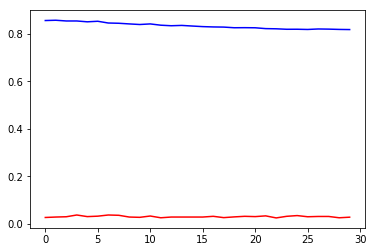

In [85]:
#increase batch size
adam = Adam(lr=0.0001)
model7.compile(loss= 'categorical_crossentropy' , optimizer= adam , metrics=[ 'accuracy' ])

# Fit the model
t0=time.time()
log7 = model7.fit(Xtr, ytr, validation_split=0.2, epochs=30, batch_size=256, verbose=2)
t1=time.time()
print(t1-t0," seconds")

# Final evaluation of the model
scores7 = model7.evaluate(Xv, yv, verbose=0)
print("CNN7 Error: %.2f%%" % (100-scores5[1]*100))

import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(log7.history['acc'],'b') 
plt.plot(log7.history['val_acc'],'r')
plt.show()

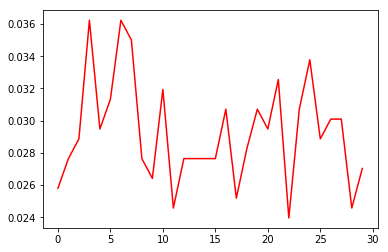

In [86]:
plt.plot(log7.history['val_acc'],'r')
plt.show()

In [90]:
def model8():
    inputs = Input(Xtr.shape[1:])
    x = Conv2D(32, 1, activation ='relu', padding='same')(inputs)
    x = MaxPooling2D((2,2))(x)
    i1 = inception2L(x)
    d = MaxPooling2D((2,2))(i1)
    d = Flatten()(d)
    d = Dense(128)(d)
    d = BatchNormalization()(d)
    d = Activation('tanh')(d)
    d = Dropout(0.5)(d)
    out = Dense(120, activation='sigmoid')(d)
    model = Model(inputs, out)
    return model

def train(model, lr=0.001, batch=32, epochs=20):
    adam = optimizers.Adam(lr=lr) 
    model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])
    result = model.fit(Xtr, ytr, batch_size=batch, epochs=epochs,verbose=0)
    return result.history

In [ ]:
for ep in [10,20,50,100,200]:
    for lr in [0.1,0.01,0.001,0.0001,0.00001]:
        model = model8()
        res = train(model,lr,32,ep)
        print(ep,lr,np.argmax(res['acc']),'{:.3f}'.format(max(res['acc'])))

10 0.1 2 0.992
10 0.01 1 0.992
10 0.001 8 0.992
10 0.0001 9 0.991
10 1e-05 9 0.731
20 0.1 3 0.992
20 0.01 19 0.992
20 0.001 19 0.992


In [ ]:
10 0.1 2 0.992
10 0.01 1 0.992
10 0.001 8 0.992
10 0.0001 9 0.991
10 1e-05 9 0.731
20 0.1 3 0.992
20 0.01 19 0.992
20 0.001 19 0.992

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

for ep in [10,20,50,100,200]:
    for lr in [0.1,0.01,0.001,0.0001,0.0001]:
        model = model7()
        res = train(model,lr,32,ep)
        plt.ylim(0,1)
        plt.xlim(0,ep)
        plt.plot(res['acc'],label='lr='+str(lr)+' ep='+str(ep))
        plt.legend()
    plt.show()    

In [ ]:
model = model8()
res = model.fit(Xtr, ytr, validation_split=0.33, epochs=20, batch_size=32)

In [ ]:
lt.plot(res.history['acc'],'b')
plt.plot(res.history['val_acc'],'g')

In [ ]:
def train_val(model, lr=0.001, batch=32, epochs=20): # runtraining with validation holdout
    adam = optimizers.Adam(lr=lr) 
    model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])
    result = model.fit(Xtr, ytr, batch_size=batch, epochs=epochs,validation_split=0.2, verbose=0)
    return result.history, model

def runeval(model):    
    t0=time.time()
    res, model = train_val(model,lr=0.001,batch=32,epochs=100)
    t1=time.time() #I'm timing to check training time vs model size
    metric = model.evaluate(Xv, yv, batch_size=32, verbose=0) 
    print(nlayer, '{:.3f}'.format(t1-t0), model.count_params(),'acc_max_tr:','{:.3f}'.format(max(res['acc'])),'acc_max_val:','{:.3f}'.format(max(res['val_acc'])),'@',np.argmax(res['val_acc']),'acc_test:',metric[1])

for nlayer in [1,5,10,20,50]:
    model = model_nlayer(nlayer)
    runeval(model)


In [ ]:
from keras.callbacks import EarlyStopping
def train_ES(model, lr=0.001, batch=64, epochs=20): # runtraining with validation holdout
    earlystop = EarlyStopping(monitor='val_acc', min_delta=0.01, patience=50, verbose=1, mode='auto')
    callbacks_list = [earlystop]
    adam = optimizers.Adam(lr=lr) 
    model.compile(optimizer=adam, loss ='binary_crossentropy', metrics=['accuracy'])
    result = model.fit(Xtr, ytr, batch_size=batch, epochs=epochs, validation_split=0.2, verbose=0, callbacks=callbacks_list)
    return result.history, model



In [ ]:
def evalES(model):    
    t0=time.time()
    res, model = train_ES(model,lr=0.001,batch=64,epochs=500)
    t1=time.time() #I'm timing to check training time vs model size
    metric = model.evaluate(Xv, yv, batch_size=32, verbose=0) 
    print(nlayer, '{:.3f}'.format(t1-t0), model.count_params(),'acc_max_tr:','{:.3f}'.format(max(res['acc'])),'acc_max_val:','{:.3f}'.format(max(res['val_acc'])),'@',np.argmax(res['val_acc']),'acc_test:',metric[1])

In [ ]:
for nlayer in [1,5,10,20,50]:
    model = model_nlayer(nlayer)
    evalES(model)

In [ ]:
for nlayer in [1,3,5,10,20,50]:
    model = model_nlayer(nlayer)
    evalES(model)
# Early stop may not work well 